## Introduction

### This notebook generates synthetic seismograms and noise-correlation functions using the Generalized Interferometry scripts. This also serves as a brief "tour" of the package, but see the original code for a complete description: https://cos.ethz.ch/software/research/gi.html


### This can be skipped if pre-computed data have been downloaded

In [1]:
# Python 3.7

import sys
sys.path.append('../GI1_v0.2.1')
sys.path.append('../GI1_v0.2.1/PLOT/')
sys.path.append('../GI1_additions')


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import green as g
import source as s
import processing as proc
import parameters
import time
import random
from correlation_random import *
from correlation_function import *
from correlation_field import *
from kernels import *
from adsrc import *
from earthquakes import *

# The following are newly added, as compared to the original GI code.
from generate_random_signals import *
from specshift import *

%matplotlib inline

In [2]:
mpl.rcParams['figure.figsize'] = [20, 10]

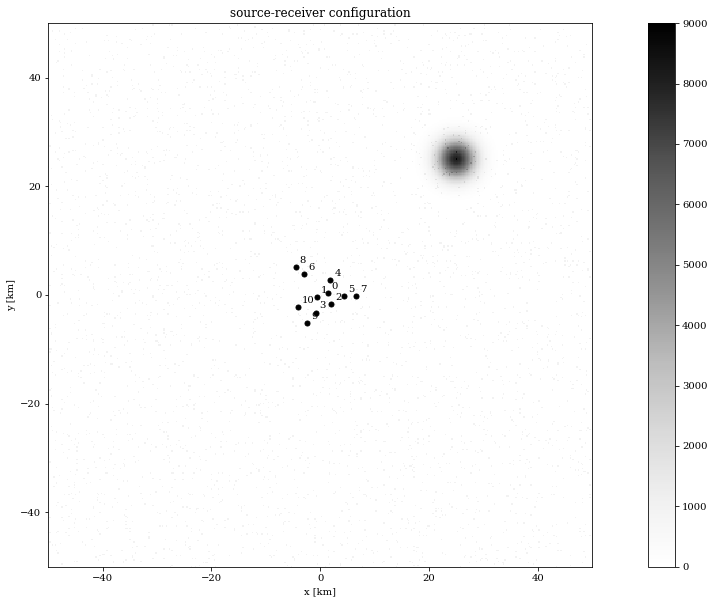

In [3]:
# First we look at our distribution of stations, defined in "./INPUT/receivers.txt"
#
# And also the noise sources, defined in "./INPUT/setup.txt"
# This can be set to type=gauss, homogeneous, random, etc., 
#  each of which is hardcoded into source.py

S,indeces=s.space_distribution(plot=True)

# Setting "./INPUT/earthquake_catalogue.txt": Neq=0
# This would superimpose an earthquake signal ontop of the noise
# The command "earthquakes()" would show this distribution

# The spatial grid resolution can be adjusted in "./INPUT/setup.txt"
# The frequency range can be adjusted in "./INPUT/correlation_field_and_kernels.txt", 
#  but then be sure to also adjust the bandpass filter in "./INPUT/processing.txt"

# Note, space_distribution() and earthquakes() are both called later by other functions.
# We're just looking at them here for visualisation purposes.

1552.9947469576193
559.8785394945049
2622.3106376648057
3295.4596198451422
3436.755277456339
4551.137721259928
4773.140339611753
6767.322536946074
6760.727346510063
5614.98403722219
4585.204041122815


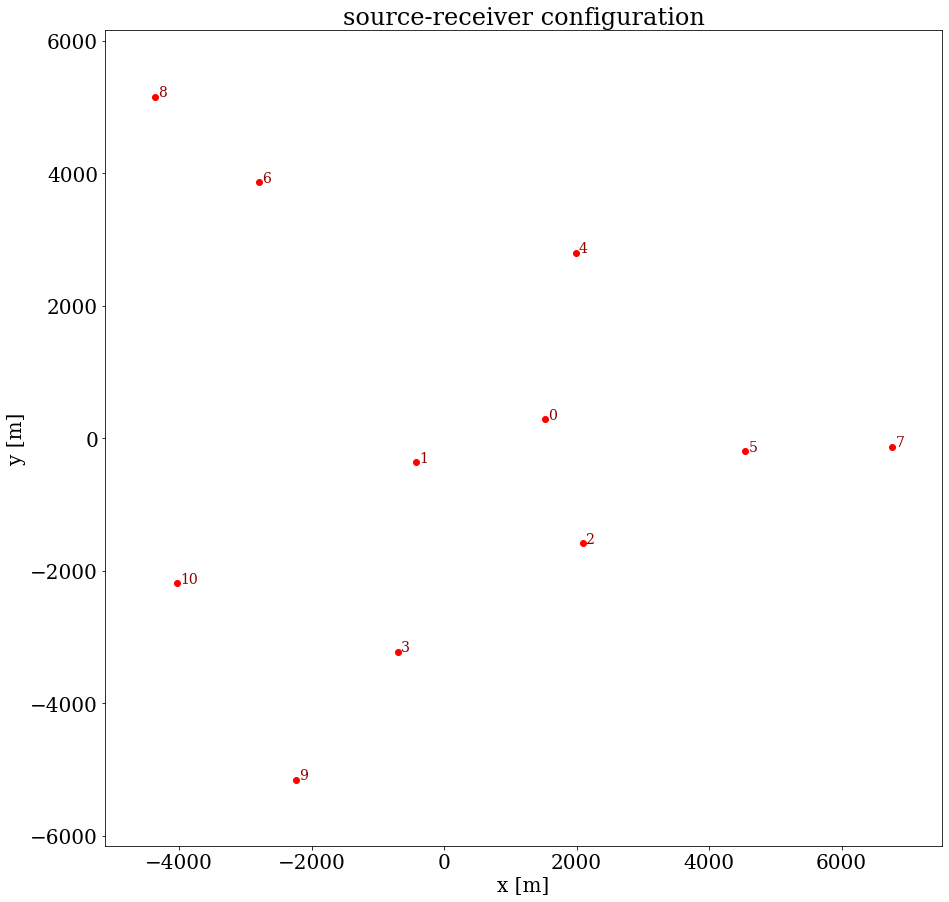

In [5]:
# In addition to the built in plotting function above, we can make a quick custom plot of the station distribution

p=parameters.Parameters()

mpl.rc('font', **{'size':20})
fig = plt.figure(figsize=(15,15))

font = {'color'  : 'darkred', 'weight' : 'normal', 'size'   : 14,}
for k in range(p.Nreceivers):
    plt.plot(p.x[k],p.y[k],'ro')
    plt.text(p.x[k]+0.2*p.dx,p.y[k],str(k),fontdict=font)
    print(np.sqrt(p.x[k]**2+p.y[k]**2))
    
plt.axis('image')
plt.axis('equal')
plt.xlim((np.min(p.x)-1000,np.max(p.x)+1000))
plt.ylim((np.min(p.y)-1000,np.max(p.y)+1000))
plt.xlabel('x [m]')
plt.ylabel('y [m]')

# plt.plot([np.min(x), np.max(x)],[0,0],'k')
# plt.plot([0,0],[np.min(y), np.max(y)],'k')
plt.title('source-receiver configuration')
#plt.colorbar()
plt.show()



number of samples: 16384
maximum time: 14.899999999999892 s
maximum frequency: 9.9993896484375 Hz


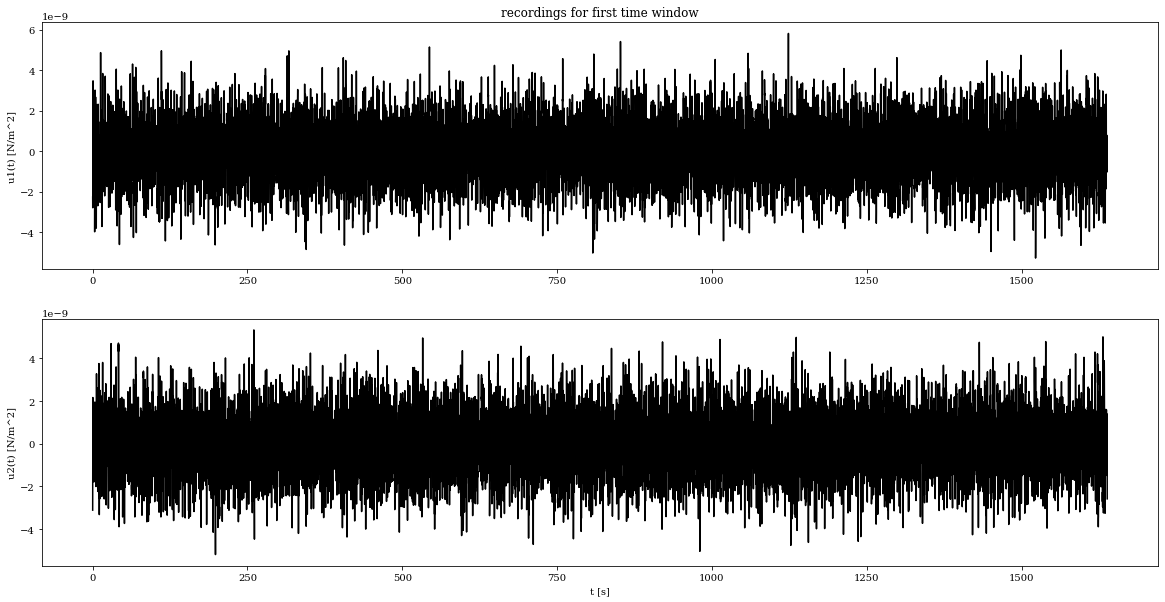

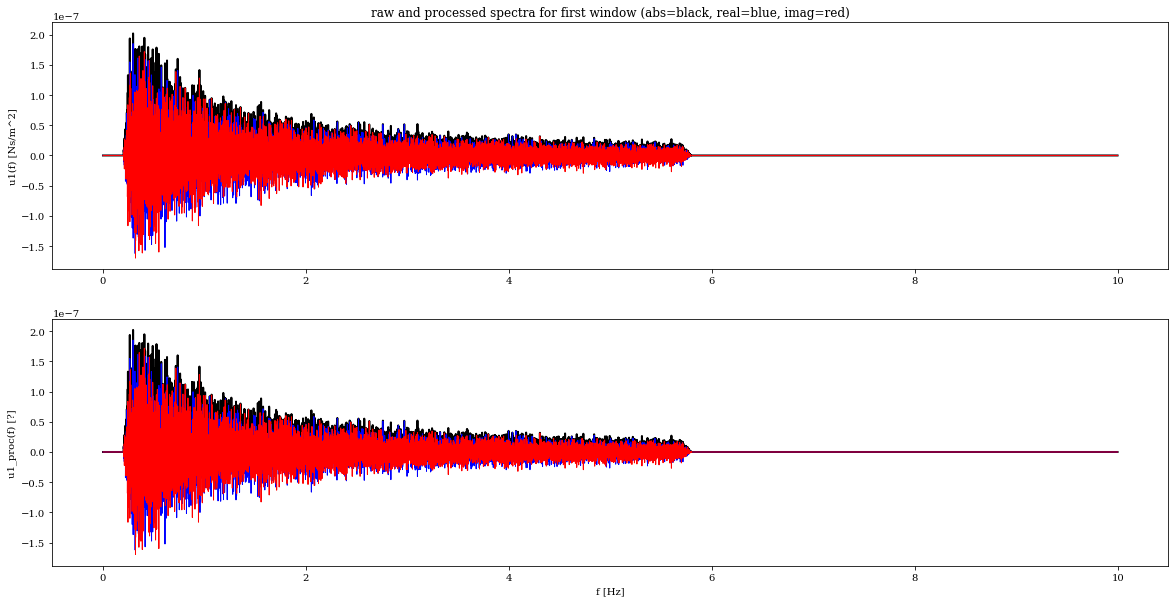

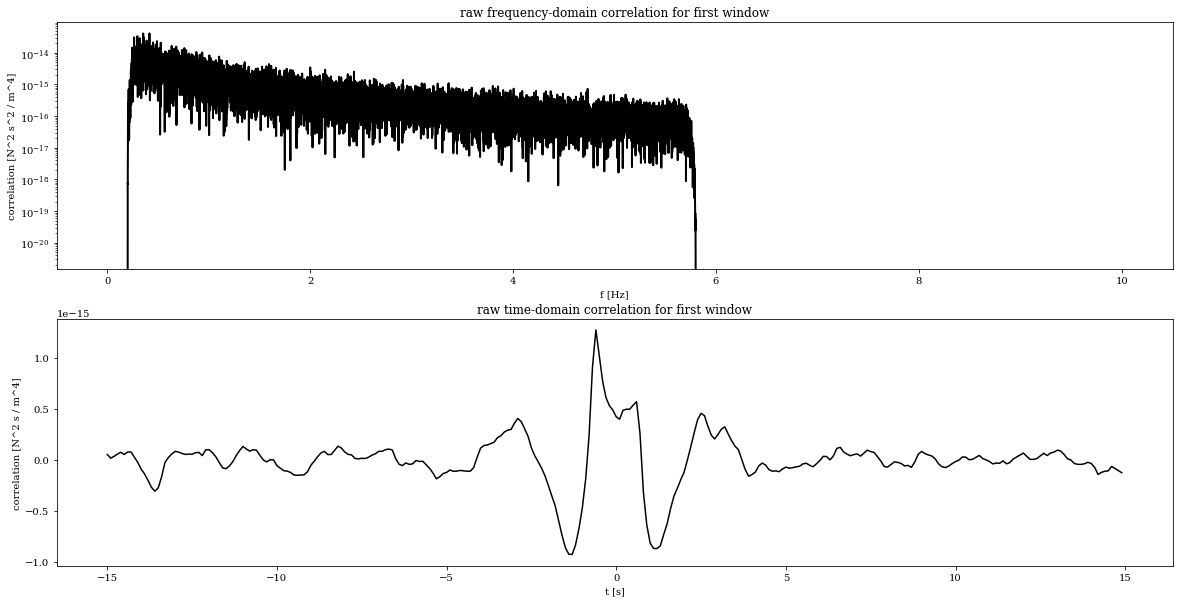

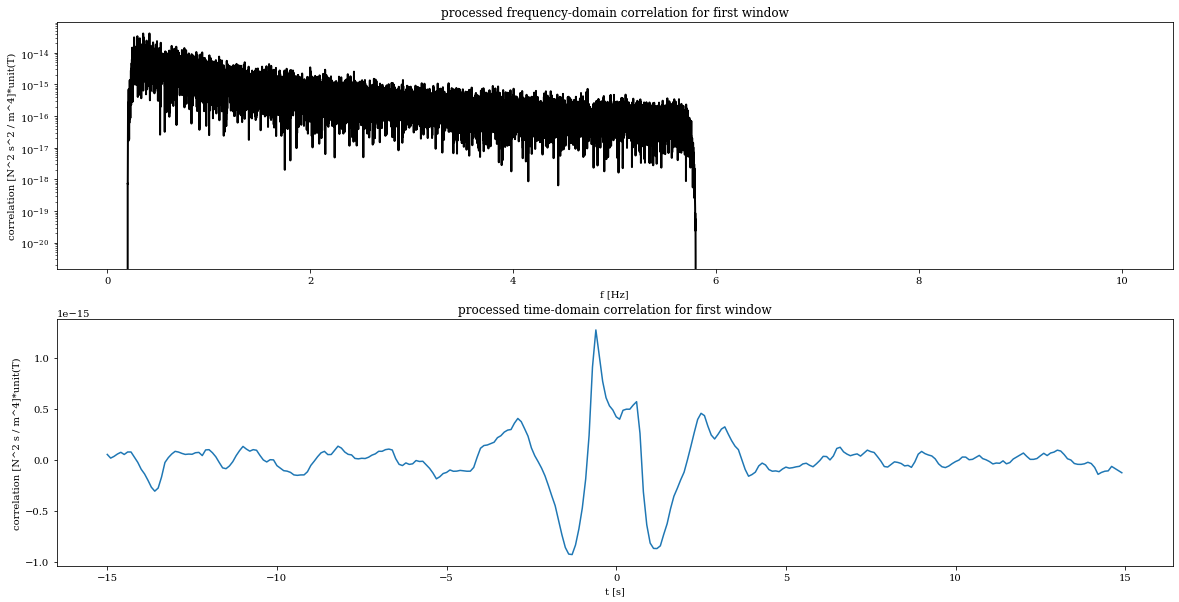

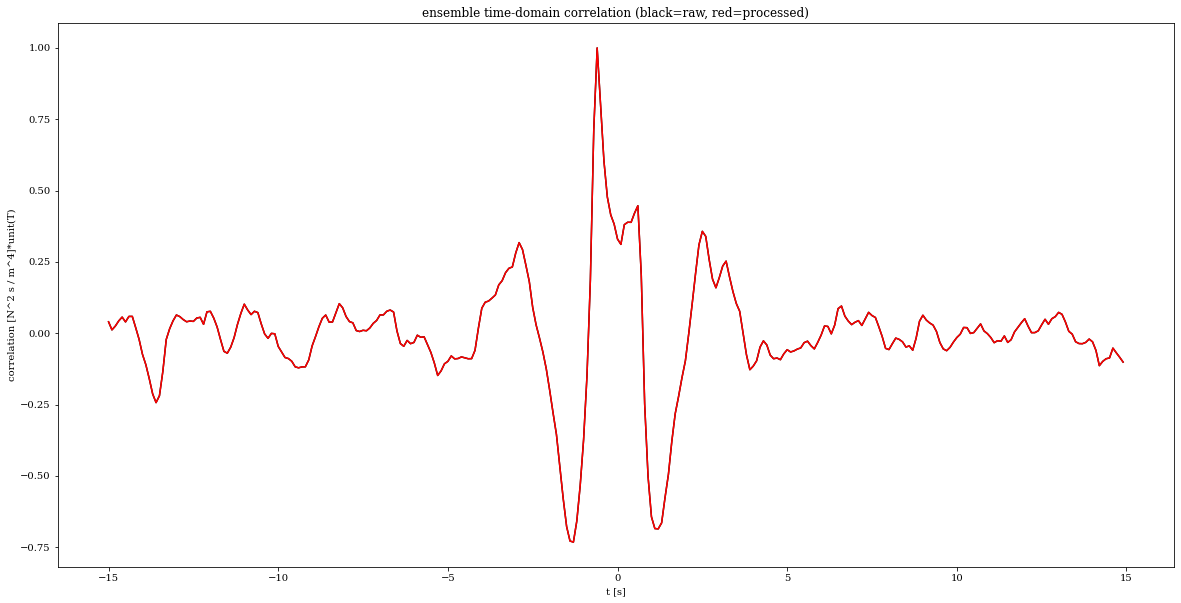

elapsed time: 10.661832332611084 s


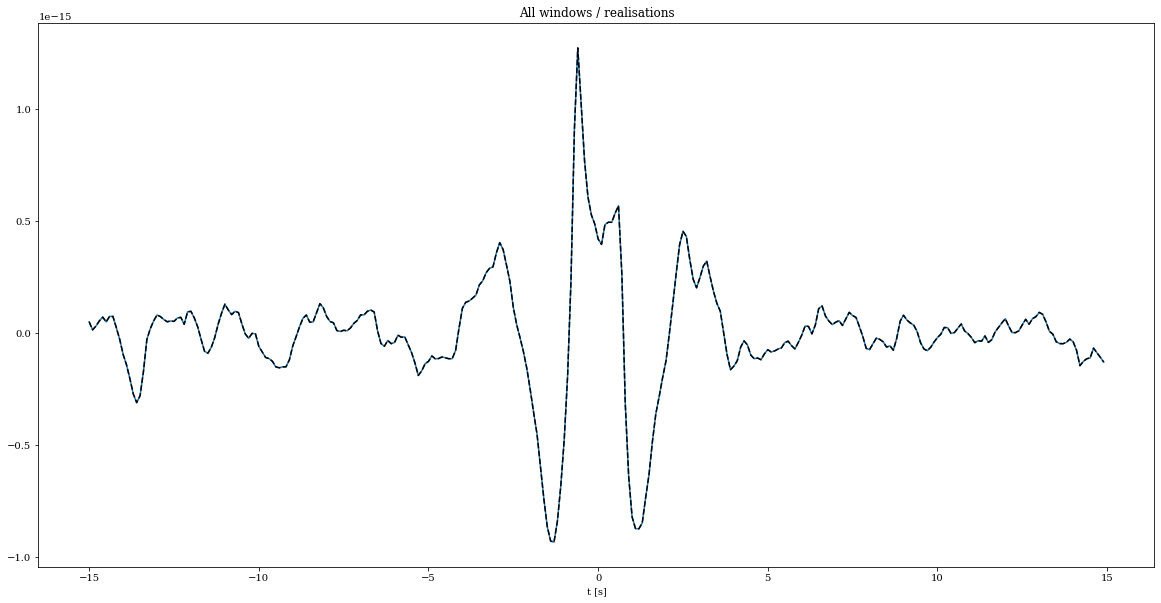

In [6]:
# The following will generate noise traces at each station, potentially many windows / realizations
#  and then cross-correlate in the standard way.
# ("./INPUT/ensemble_correlations.txt")

# This works by analytically defining the frequency-domain Green's function from each noise source 
#  to receiver, then filling with a vector of random phases to represent a given realization
# 

cct,cct_proc,t,ccf,ccf_proc,f=correlation_random(rec0=0,rec1=1,verbose=True,plot=True,save=False)

# cct will have dimensions( length(t), number_of_windows )

plt.plot(t,cct)
plt.plot(t,np.mean(cct,1),linestyle='--',color='k')
plt.xlabel('t [s]')
plt.title('All windows / realisations')
plt.show()

In [ ]:
# This command will compute the correlation wavefield directly, adjoint style.
#
# This creates the noise-correlation function without the need for multiple realisations.
# Ideally, it would match the "traditional" noise correlations, if enough averaging was performed.

cct,t,ccf,f = correlation_function(rec0=0,rec1=1,effective=0,plot=1,save=0)

# Grey lines in the final correlation function plot indicate where the Green's function arrival should be
#  if noise sources were perfectly distributed


number of samples: 16384
maximum time: 14.899999999999892 s
maximum frequency: 9.9993896484375 Hz


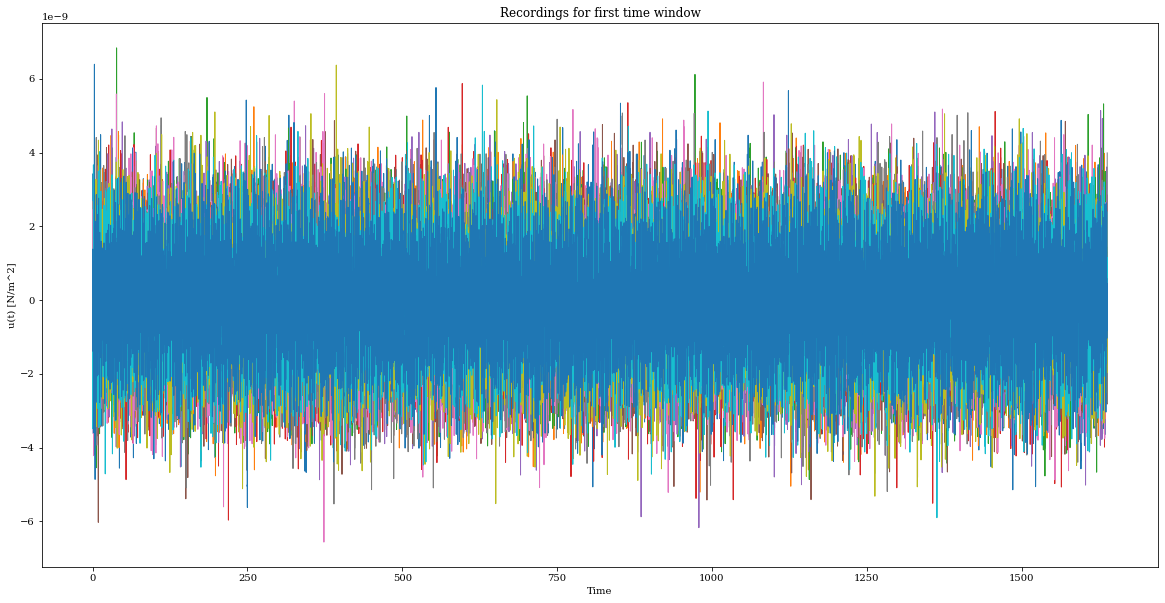

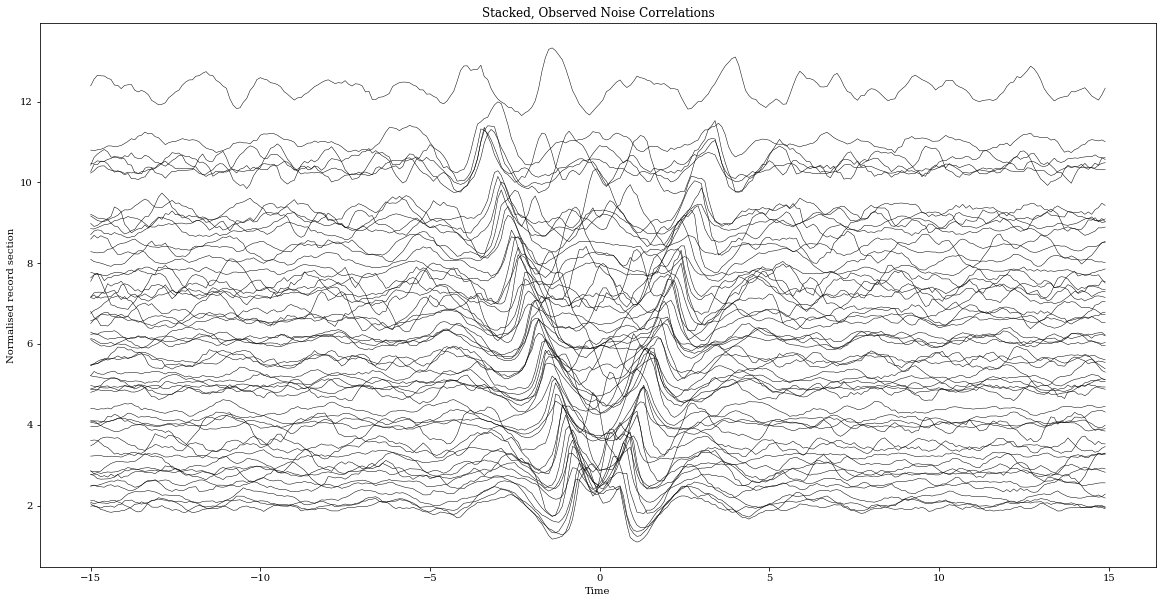

elapsed time: 42.46245718002319 s


In [8]:
# Now loop through and calculate observed NCF's all the station-station pairs,
#  saving them for later.

# We could loop through each station-station pair, calling "correlation_random(...,save=1)"
# But the following is a bit faster (generates the wavefield once, for all stations, then correlates)
ut,traw,cct,t,ccf,f = generate_random_signals(verbose=True,plot=True,save=True,return_cc=True)

#ut and traw are for the raw time-domain traces. We'll use that later in beamforming.

In [ ]:
# Explore some other tools in the code.
# These are used in other notebooks, but included here for completeness.

# One source kernel
cct,t,ccf,f = correlation_function(rec0=0,rec1=1,effective=0,plot=0)
x,y,K_kappa = source_kernel(cct, t, rec0=0, rec1=1, measurement='amp', effective=0, plot=1)
# measurement can be either 'amp' or 'cctime'. This changes the misfit to be used.